# **Loading Images Using `tf.data.Dataset`**

**Learning objectives**
1. Retrieve images using `tf.keras.utils.get_file`
2. Load images using Keras Pre-Processing
3. Load images using `tf.data.Dataset`
4. Understand basic methods for training

## **Introduction**

In this notebook, we load an image data set using `tf.data`. The data set used in this example is distributed as directories of images, with one class of image per directory.

### **Setup**

### **Load necessary libraries**

In [1]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.4.1


In [4]:
# It contains experimental Dataset sources and transformations that can be used in conjunction with the tf.data.Dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE

### **Retrieve the images**

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognise. You can use an archive of creative-commons licensed flower photos from Google.

In [5]:
# Importing pathlib to import necessary set of images
import pathlib
data_dir = tf.keras.utils.get_file(origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
                                   fname="flower_photos",
                                   untar=True)

228818944/228813984 [==============================] - 319s 1us/step


In [7]:
data_dir = pathlib.Path(data_dir)

The directory contains 5 sub-directories, one per class:

In [8]:
# Print the image count
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

3670

In [9]:
# Here, `np.array()` method creates an array
CLASS_NAMES = np.array([item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'tulips', 'dandelion', 'roses', 'sunflowers'],
      dtype='<U10')

Each directory contains images of that type of flower. Here are some roses:

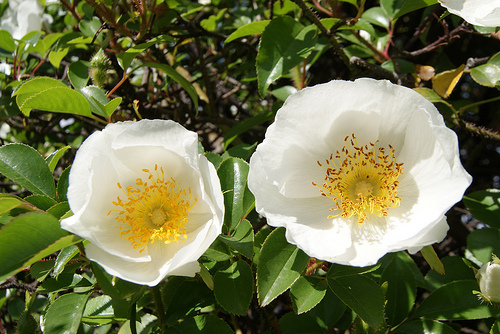

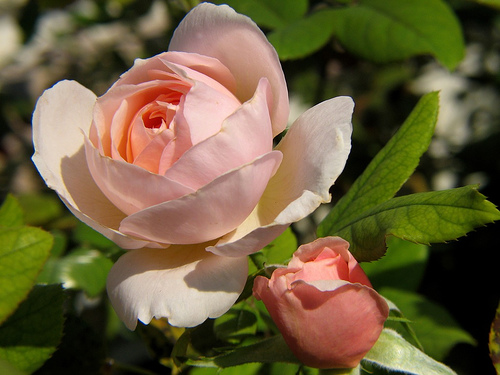

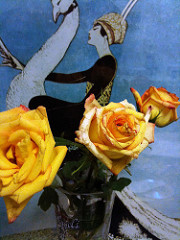

In [10]:
# Here, `Image.open()` method Opens and identifies the given image file
roses = list(data_dir.glob("roses/*"))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## **Load using `tf.keras.preprocessing`**

A simple way to load images is to use `tf.keras.preprocessing` 

In [11]:
# The 1./255 is to convert from uint8 to float32 in range [0,1]
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Define some parameters for the loader:

In [14]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [15]:
# Generate batches of tensor image data with real-time data augmentation
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


Inspect a batch

In [16]:
# Here, define show_batch() procedure for inspecting a batch
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis("off")

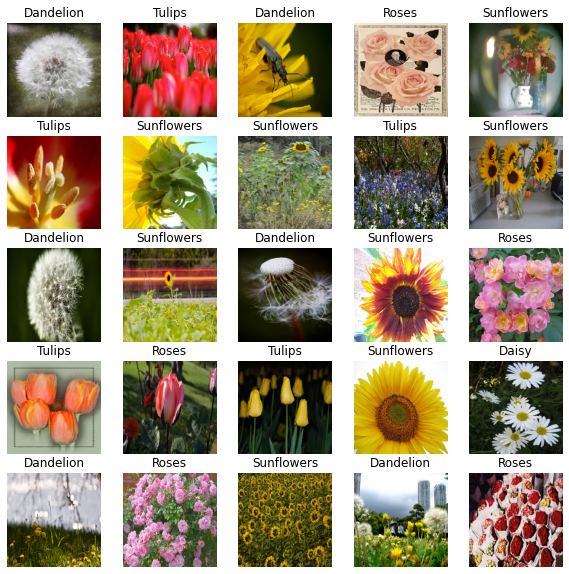

In [17]:
# Here, `next()` function returns the next item in an iterator
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## **Load using `tf.data`**

The above `tf.keras.preprocessing` method is conveinient, but has three downsides:

1. It's slow
2. It lacks fine-grained control
3. It is not well integrated with the rest of TensorFlow

To load the files as a `tf.data.Dataset` first create a data set of the file paths:

In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir/"*/*"))

In [23]:
# Here, .take() method returns elements from array along the mentioned axis and indices
for f in list_ds.take(5):
    print(f.numpy())

b'/home/antounes/.keras/datasets/flower_photos/dandelion/480621885_4c8b50fa11_m.jpg'
b'/home/antounes/.keras/datasets/flower_photos/sunflowers/19595718862_c68896370c_m.jpg'
b'/home/antounes/.keras/datasets/flower_photos/tulips/6187740107_9813ccc41e.jpg'
b'/home/antounes/.keras/datasets/flower_photos/sunflowers/3815322974_52c12dbde3.jpg'
b'/home/antounes/.keras/datasets/flower_photos/daisy/5973491805_556bba93cc.jpg'


Write a short pure-tensorflow function that converts a file path to an `(img, label)` pair:

In [24]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [28]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [26]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(tf.io.read_file(file_path))
    return img, label

Use `Dataset.map` to create a data set of `(image, label)` pairs:

In [29]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
# Print the value of `Image shape` and `label`
for image, label in labeled_ds.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())

Image shape: (224, 224, 3)
Label: [False  True False False False]


## **Next Steps: Basic methods for training**

To train a model with this data set you will want the data:
- to be well shuffled
- to be batched
- batches to be available as soon as possible

These features can be easily added using the `tf.Data` API

In [31]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small data set, only load it once, and keep it in memory
    # Use `.cache(filename)` to cache preprocessing work for data sets that don't fit in memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    # Repeat forever
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    # `prefetch` lets the data set fetch batches in the background while the model is training
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [32]:
# Here, the `next()` function returns the next item in an iterator
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

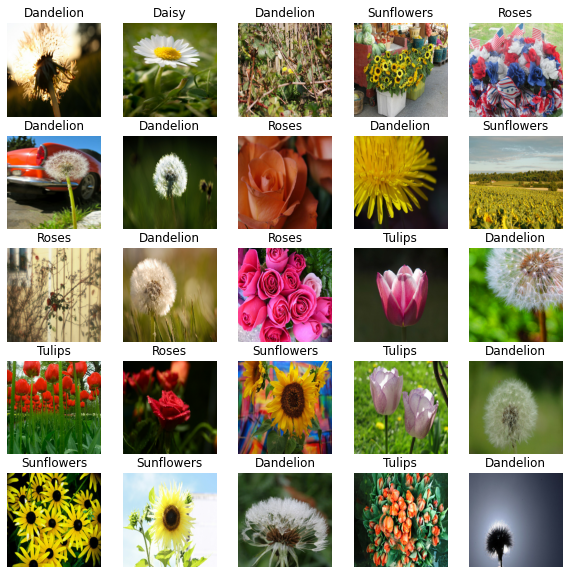

In [33]:
show_batch(image_batch.numpy(), label_batch.numpy())